# Feature engineering

In this session we will practice extracting and transforming features from MEG data and from text data. We will also be checking how our features work with classification algorithms.

## Magnetoencephalography

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/NIMH_MEG.jpg/435px-NIMH_MEG.jpg" width=300px>

Magnetoencephalography (MEG) is a functional neuroimaging technique for mapping brain activity by recording magnetic fields produced by electrical currents occurring naturally in the brain, using very sensitive magnetometers (https://en.wikipedia.org/wiki/Magnetoencephalography).


### MEG dataset

The original dataset comes from http://www.cis.hut.fi/icann2011/mindreading.php

- Subject watches video clips
  - artificial, football, nature, Mr Bean, Chaplin
- MEG recorded
  - 1 second @ 200Hz
  - 204 channels
- Experiment repeated on another day
- Task: brain decoding
  - given MEG recording, guess category of video
  
Let's load the data.  

**NOTE** if you kernel gets killed, make sure to close other open notebooks. Or use a subset of the data.

In [1]:
import numpy as np
# Use a subset of data because of server limits
train_signal = np.load("/srv/megicann/train_signal.npy")
valid_signal = np.load("/srv/megicann/valid_signal.npy")
y_train = np.load("/srv/megicann/train_target.npy")
y_valid = np.load("/srv/megicann/valid_target.npy")

In [3]:
print((train_signal[0]))

[[  4.46784672e-13   3.97233592e-12   1.14859832e-11 ...,   1.90807474e-11
    1.83620740e-11   1.88269626e-11]
 [  1.12278286e-12   4.03432973e-12  -7.83521956e-13 ...,  -4.55584442e-12
   -5.09393179e-12  -4.45715253e-12]
 [ -1.12883921e-11  -8.92157615e-12  -4.17323164e-12 ...,   5.82785556e-12
    9.33283138e-12   5.62020179e-12]
 ..., 
 [ -1.79998655e-11  -1.71349167e-11  -9.79247412e-12 ...,  -7.30610451e-12
   -8.28041542e-12  -1.14775654e-11]
 [ -7.61813355e-12  -4.27003268e-12  -6.47280016e-12 ...,  -1.09402314e-11
   -5.62712203e-12  -2.86472560e-12]
 [ -1.52484553e-11  -1.42702005e-11  -7.22551229e-12 ...,   8.70339564e-12
    4.59656965e-12   1.51834654e-12]]


In [4]:
print(train_signal.shape)

(677, 204, 200)


And let's plot a few of the channels.

Populating the interactive namespace from numpy and matplotlib


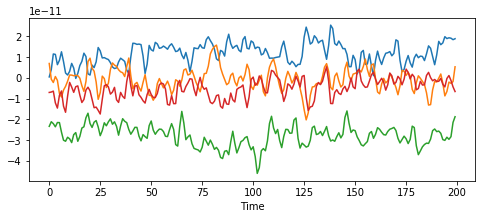

In [2]:
%pylab inline --no-import-all
plt.figure(figsize=(8,3))
for i in [0, 10, 100, 200]:
    pylab.plot(train_signal[0,i,:])
pylab.xlabel("Time")

### Exercise A1

Complete the function `majority` which finds out the majority baseline. The function should check which class is most common in the training data `train`, and what proportion of examples in the test data `test` belongs to this class.

In [6]:
def majority(train, test):
    # .................................................................

    classes, counts = np.unique(train, return_counts=True)
    classes_test, counts_test = np.unique(test, return_counts=True)
    maj = np.argmax(counts)
    return counts_test[maj]/np.sum(counts_test)
    

print(majority(y_train, y_valid))
print(majority(y_train, y_train))

0.2
0.25258493353


### Exercise A2

Complete function `features_mean` which extracts and returns time-wise means of a multichannel singal. The input signal is a three-dimensional array of shape `(example, channel, time)`. The output should be a two-dimensional array of shape `(example, channel)`.

In [3]:
def features_mean(signal):
    #...............................
    return signal.mean(axis=2)

### Exercise A3

Evaluate the performance of the Perceptron classifier on the MEG data using time-wise mean per channel as the input features. Train on the training data and evaluate on the validation data. Set `random_state` to a fixed integer. Evaluate the classifier for several values of `n_iter` (i.e. number of passes).

In [4]:
# ...................................................
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

X_train = features_mean(train_signal)
X_valid = features_mean(valid_signal)
print("Passes\t Acc")
for passes in [5, 10, 20, 40]:
    model = Perceptron(random_state=666, n_iter=passes)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_valid, model.predict(X_valid))
    print("{}\t {}".format(passes, acc))

Passes	 Acc
5	 0.18
10	 0.2
20	 0.38
40	 0.26


### Exercise A4

Complete function `features` below, which takes a signal (as a three-dimensional array), a list of feature functions, and returns an array with all the features extracted by the functions, concatenated together. Each feature function in the list can be applied to a 3-dimensional signal of shape `(example, channel, time)`, and will reduce it to a two-dimensional array along the axis specified via the `axis` keyword argument.

You may find the functions `np.concatenate` or `np.hstack` useful.

In [12]:
type(train_signal)

numpy.ndarray

In [9]:
def features(signal, functions):
#.........................................    
    return np.concatenate([ function(signal, axis=2) for function in functions ], axis=1)

summaries = [np.mean, np.min, np.max, np.std]

X_train = features(train_signal, summaries)
print("Input shape {}".format(train_signal.shape))
print("The resulting shape should be {}".format(
        (train_signal.shape[0], train_signal.shape[1]*len(summaries))))
print(X_train.shape)

Input shape (677, 204, 200)
The resulting shape should be (677, 816)
(677, 816)


### Exercise A5 

Compute the performance of the Perceptron classifier on the full set of summary features. Then leave out each feature in turn and calculate the change in performance. 


In [9]:
# ...........................................
def best(X, y, X_val, y_val):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_val = scaler.transform(X_val)
    acc = []
    for passes in [5, 10, 20, 40]:
        model = Perceptron(random_state=666, n_iter=passes)
        model.fit(X, y)
        acc.append(accuracy_score(y_val, model.predict(X_val)))
    return np.max(acc)

from sklearn.preprocessing import StandardScaler


X_train = features(train_signal, summaries)
X_valid = features(valid_signal, summaries)
acc = best(X_train, y_train, X_valid, y_valid)
print("All {}".format(acc))

for i in range(len(summaries)):
    fs = summaries[:i] + summaries[i+1:]
    X_train = features(train_signal, fs)
    X_valid = features(valid_signal, fs)
    this = best(X_train, y_train, X_valid, y_valid)
    print("{} {}".format(summaries[i].__name__, this))


All 0.54
mean 0.48
amin 0.54
amax 0.48
std 0.56


## Same or different

This dataset was created by asking people to look at and describe photographs. Each example consists of a pair of descriptions, and the target is either 1, if the descriptions are of the same photo, or 0 if they are of different photos.

### Loading 
We can use the `pandas.read_csv` function to load the csv files with the data.

In [1]:
import pandas as pd

In [2]:
train_input = pd.read_csv("/srv/same/same-or-diff-train-features.csv")
train_target = pd.read_csv("/srv/same/same-or-diff-train-label.csv")
test_input = pd.read_csv("/srv/same/same-or-diff-test-features.csv")
test_target = pd.read_csv("/srv/same/same-or-diff-test-label.csv")

In [3]:
train_input.head()

,Id,Sentence1,Sentence2
0,0,young boy sitting down eating a hot dog,A soccer game with players defending the ball
1,1,The lights are still on and no one is around.,"Two toilets, one with a brown lid and one with..."
2,2,there are many different signs on this street ...,some street signs on a pole next to a big buil...
3,3,BEAUTIFUL COLORED LARGE POTS FILLED WITH PLANT...,Potted plants near a park and trees.
4,4,A woman and a girl are standing beside a Chris...,Lady and child standing by Christmas tree in f...


In [13]:
train_target.head()

,Id,Prediction
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


Pandas uses data frames to store the data. We can convert these to simple lists or to numpy arrays which can be more convenient to work with.

In [5]:
import numpy as np

In [6]:
y_train = np.array(train_target['Prediction'])
y_test = np.array(test_target['Prediction'])

In [7]:
print(y_train.shape)
print(y_test.shape)

(180000,)
(10000,)


In [8]:
train_text = np.array(train_input[['Sentence1', 'Sentence2']])
test_text = np.array(test_input[['Sentence1', 'Sentence2']])

In [11]:
train_text[:,0]

array(['young boy sitting down eating a hot dog',
       'The lights are still on and no one is around.',
       'there are many different signs on this street pole', ...,
       'A computer desk has two monitors and a desk chair.',
       'A young woman is dressed in gothic clothing. ',
       'Men in a park with frisbee, with trees, portable toilets, fence, bags, and other people in background.'], dtype=object)

### Exercise B1

Complete the following function `counts` which extracts word counts from both columns of the same-of-different dataset.



In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

def counts(train_text, test_text):
#........................................    
    #Use the object `sklearn.preprocessing.text.CountVectorizer` to extract word counts 
    #from the first column and the second column of the same-or-different dataset. 
    
    vec1 = CountVectorizer()
    vec2 = CountVectorizer()

    train_counts1 = vec1.fit_transform(train_text[:,0])
    train_counts2 = vec2.fit_transform(train_text[:,1])
    test_counts1 = vec1.transform(test_text[:,0])
    test_counts2 = vec2.transform(test_text[:,1])
    #Then use the function `scipy.sparse.hstack` to create a single matrix which holds 
    #word counts for both the first and the second sentence.

    train_counts = hstack([train_counts1, train_counts2])
    test_counts = hstack([test_counts1, test_counts2])
    
    
    return (train_counts, test_counts)


In [13]:
# Avoid killing the kernel by only using 1/10 of the data
X_train, X_test = counts(train_text[:18000], test_text)
y_train = y_train[:18000]
print(X_train.shape)
print(X_test.shape)

(18000, 12922)
(10000, 12922)


### Exercise B2

Test the performance of the Perceptron algorithm and the Decision Tree algorithm on the word count features. Test several values of number of passes (`n_iter`) for the Perceptron, and several values of `max_depth` for the decision tree.

We would expect a linear classifier (including the Perceptron) to fail to learn this task given this feature representation, i.e. the performances should around 50%. The decision tree, on the other hand, should be able to perform well above chance.

In [20]:
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

print("algo setting accuracy")
for passes in [5, 10, 20, 40]:
    model = Perceptron(n_iter=passes, random_state=123)
    model.fit(X_train, y_train)
    print("perceptron passes={} {}".format(passes, accuracy_score(y_test, model.predict(X_test))))
    
for depth in [10, 20, 40, 80]:
    model = DecisionTreeClassifier(max_depth=depth, random_state=123)
    model.fit(X_train, y_train)
    print("decision_tree depth={} {}".format(depth, accuracy_score(y_test, model.predict(X_test))))

algo setting accuracy
perceptron passes=5 0.5004
perceptron passes=10 0.5024
perceptron passes=20 0.4988
perceptron passes=40 0.5069
decision_tree depth=10 0.529
decision_tree depth=20 0.5506
decision_tree depth=40 0.5575
decision_tree depth=80 0.6033


### Exercise B3

Cosine similarity between two vectors is equivalent to the normalized dot product:
 
 $$ cosine(u, v) = \frac{u \cdot u}{||u|| \times ||v||} $$
 
It is often used as a measure of similarity between vectors, especially when the direction the vectors are pointing to is of more interest than the magnitude.

For each example of the same-or-different dataset compute the cosine of between the word-count vectors of the two sentences. Use it as the single feature to train and evaluate the Perceptron.

In [21]:
from sklearn.metrics.pairwise import paired_cosine_distances

def cosine_feat(train_text, test_text):
    vec = CountVectorizer()
    train_counts = vec.fit_transform(np.hstack([train_text[:,0], train_text[:,1]]))
    train_counts1 = train_counts[:train_text.shape[0],:]
    train_counts2 = train_counts[train_text.shape[0]:,:]
    test_counts1 = vec.transform(test_text[:,0])
    test_counts2 = vec.transform(test_text[:,1])
    train_sim = 1-paired_cosine_distances(train_counts1, train_counts2)
    test_sim = 1-paired_cosine_distances(test_counts1, test_counts2)
    return (train_sim, test_sim)

X_train, X_test = cosine_feat(train_text[:18000], test_text)

X_train = X_train.reshape((-1,1))
X_test = X_test.reshape((-1,1))

print("algo setting accuracy")
for passes in [5, 10, 20, 40]:
    model = Perceptron(n_iter=passes, random_state=666)
    model.fit(X_train, y_train)
    print("perceptron passes={} {}".format(passes, accuracy_score(y_test, model.predict(X_test))))
    
    

algo setting accuracy
perceptron passes=5 0.8027
perceptron passes=10 0.8031
perceptron passes=20 0.7955
perceptron passes=40 0.8035


We can check the weight and bias learned by the model like so:

In [22]:
model = Perceptron(n_iter=5, random_state=666)
model.fit(X_train, y_train)
print(model.intercept_)
print(model.coef_)

[-1.]
[[ 4.83352858]]


So the perceptron has learned to classify an example as positive if the cosine is greater than approximately 1/5.